In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
import seaborn as sns
import umap

In [2]:
# Shutdown RDKit logging for cleaner output
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

### Reading data

In [3]:
train = pd.read_csv('../data/asap/train.tsv', sep='\t')
test = pd.read_csv('../data/asap/test.tsv', sep='\t')
train.shape, test.shape

((434, 6), (126, 1))

In [4]:
train

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9
...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN


In [5]:
test

,smiles
0,CC(C)[C@H]1C2=C(CCN1C(=O)CC1=CN=CC3=CC=CC=C13)...
1,CC(C)C1(C)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1
2,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC2=C(C=CS2)C12CCC2
3,CC1(CC(F)(F)F)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1
4,CCC1=CC=C([C@H]2C[C@H](C)CCN2C(=O)CC2=CN=CC3=C...
...,...
121,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...
122,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...
123,COC[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN...
124,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...


### Mapping Morgan fingerprints to 2D

In [6]:
def ECFP_from_smiles(
    smiles,
    R = 2,
    L = 2**10,
    use_chirality = False
):
    molecule = AllChem.MolFromSmiles(smiles)
    if molecule is None:
        return None
    
    fpgen = AllChem.GetMorganGenerator(
        radius=R,
        fpSize=L,
        includeChirality=use_chirality
    )
    
    feature_list = fpgen.GetFingerprint(molecule)

    return np.array(feature_list, dtype=bool)

In [7]:
train_ecfp = np.array(train['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
test_ecfp = np.array(test['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train_ecfp.shape, test_ecfp.shape

((434, 1024), (126, 1024))

/opt/conda/envs/admet/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/admet/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


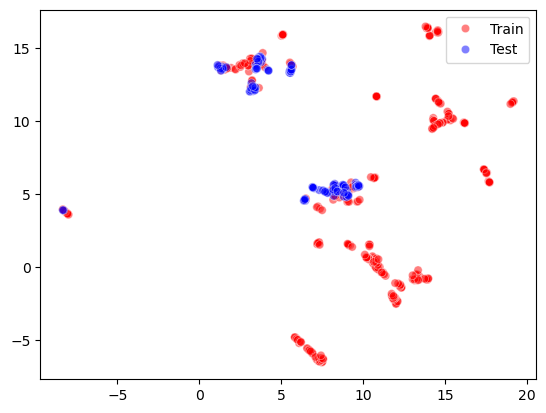

In [8]:
all_ecfp = np.concatenate([train_ecfp, test_ecfp])
all_ecfp_umap = umap.UMAP(
    n_components=2, random_state=42, n_jobs=1, metric='jaccard'
).fit_transform(all_ecfp)
sns.scatterplot(
    x=all_ecfp_umap[:, 0], y=all_ecfp_umap[:, 1], 
    hue=['Train']*len(train) + ['Test']*len(test),
    palette={'Train': 'red', 'Test': 'blue'},
    alpha=0.5
);

## Q1: Why is test set a subset of train set?
From the UMAP representation of train and test set molecules, we can see that test set lies within the train set data points. At the same time, train molecules expand the test set rather than being a random subset of the superset. From [another issue](https://github.com/asapdiscovery/asap-polaris-blind-challenge-examples/issues/11), we also know that identical molecules exist between the train and test sets. It brings at least one critical issue with evaluation: winning models should just overfit to the overlapping set of molecules in train/test sets without being trained for generalizability.

### Now, let's look at the duplicates within both train and test sets

In [9]:
def canonicalize(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

In [10]:
# After canonicalization, we lose the annotation like "|&1:3|" which isn't important for the most of prediction models
train['smiles_std'] = train['smiles'].apply(canonicalize)
test['smiles_std'] = test['smiles'].apply(canonicalize)

In [11]:
print(f"Number of duplicate SMILES in training set: {train[train['smiles_std'].duplicated()]['smiles_std'].nunique()}")

Number of duplicate SMILES in training set: 36


In [12]:
print(f"Number of duplicate SMILES in test set: {test[test['smiles_std'].duplicated()]['smiles_std'].nunique()}")

Number of duplicate SMILES in test set: 3


In [13]:
# Find a pair of molecules with identical standardized SMILES
duplicate_example = train[train['smiles_std'].duplicated()].groupby('smiles_std').first().index[0]
duplicate_pair = train[train['smiles_std'] == duplicate_example]

print("Example of duplicate molecules after standardization:")
print("\nOriginal SMILES:")
for smiles in duplicate_pair['smiles']:
    print(smiles)
print("\nStandardized SMILES:")
print(duplicate_pair['smiles_std'].iloc[0])

Example of duplicate molecules after standardization:

Original SMILES:
CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=C1 |o1:4|
CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=C1 |o1:4|
CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=C1 |&1:4|

Standardized SMILES:
CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)cc12)c1ccc2c(c1)OCCO2


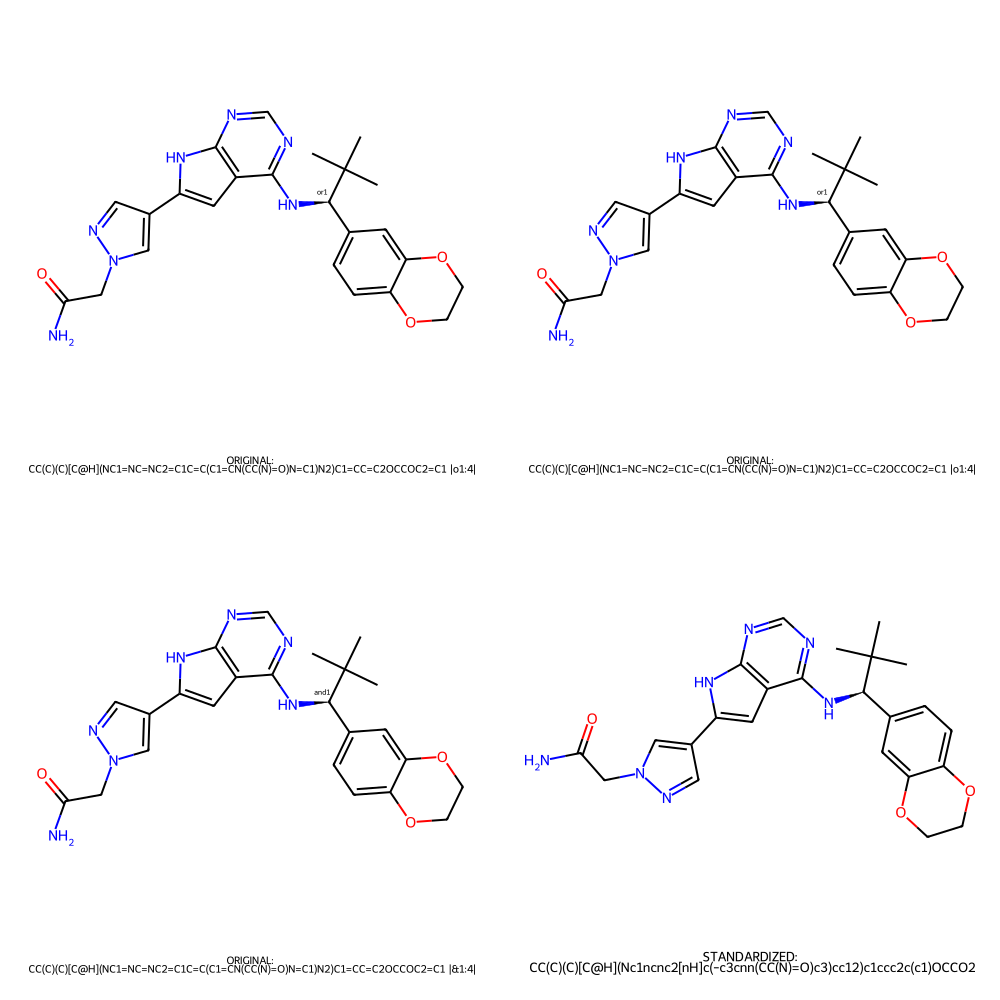

In [14]:
# Draw the duplicate molecules and their standardized form
mols = [Chem.MolFromSmiles(smiles) for smiles in duplicate_pair['smiles']]
mol_std = Chem.MolFromSmiles(duplicate_pair['smiles_std'].iloc[0])

# Add standardized molecule to the list
mols.append(mol_std)

# Create labels
labels = \
    list(map(lambda smi: f'ORIGINAL:\n {smi}', duplicate_pair['smiles'].tolist())) + \
    [f'STANDARDIZED:\n {duplicate_pair["smiles_std"].iloc[0]}']

# Draw molecules in a grid
img = Chem.Draw.MolsToGridImage(
    mols,
    legends=labels,
    molsPerRow=2,
    subImgSize=(500, 500),
    returnPNG=False
)
display(img)

It's clear that these molecules are duplicates. Now, let's look at their properties:

In [15]:
duplicate_pair

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std
294,CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N...,153.0,89.0,3.0,44.0,0.364,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...
300,CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N...,100.0,104.0,3.1,39.0,1.010,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...
386,CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N...,133.0,195.0,3.2,47.0,1.660,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...


The same molecules have different property values. Ok, this is something that we should expect from the experimental assays. But let's look at the maximum difference in the reported measurements among duplicates:

In [16]:
max_diff_in_duplicates = \
    train[train['smiles_std'].duplicated()] \
    .groupby('smiles_std') \
    .apply(lambda x: x.iloc[:, 1:].max() - x.iloc[:, 1:].min())

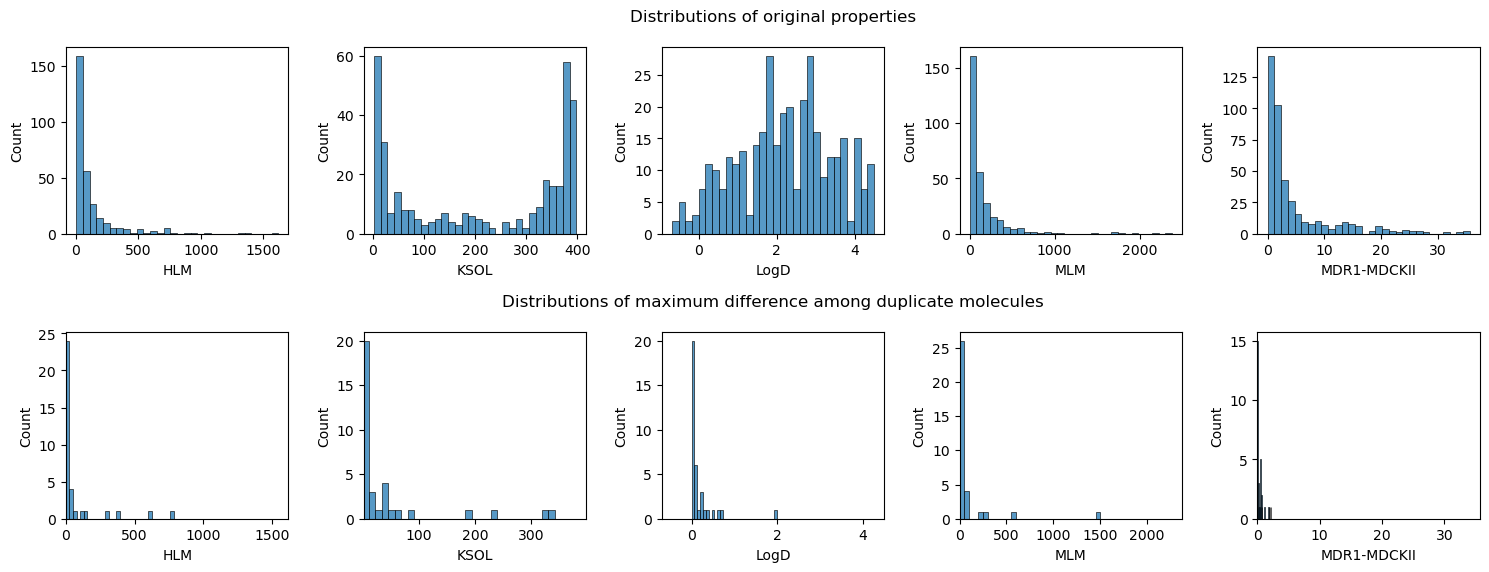

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
# plot original histograms
fig.suptitle('')  # Add empty suptitle to create space
ax[0,2].set_title('Distributions of original properties', pad=5, y=1.1)
for i, col in enumerate(train.columns[1:6]):
    sns.histplot(train[col], ax=ax[0, i], bins=30)
# plot histograms of max differences  
ax[1,2].set_title('Distributions of maximum difference among duplicate molecules', pad=5, y=1.1)
for i, col in enumerate(max_diff_in_duplicates.columns):
    sns.histplot(max_diff_in_duplicates[col], ax=ax[1, i], bins=30)
    ax[1, i].set_xlim(train[col].min(), train[col].max())

plt.tight_layout()

## Q2: How does evaluation take care of long-tail outliers?
From the two plots above, we see that the maximum difference in measurements for duplicate molecules spreads through the whole overall distribution range of the properties for at least HLM, MLM, and KSOL. The competition description says, "We will evaluate your submission using MAE on the log transformed endpoints, after clipping to the strictly positive detection limit. This minimises the effect of massive outliers on the MAE".  

The quote above mentions clipping to a positive range, but what about the long-tail outliers that seem to happen due to the noisy nature of data? Without caring for those outliers, the calculated MAE will favor models that better guess the noisy part of the property distributions.